In [1]:
import tensorflow as tf
import time
import numpy as np
import matplotlib
%matplotlib inline
import pylab as plt
import seaborn as sns
#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

In [2]:
def DisplayArray(a, fmt='jpeg', rng=[0,1]):
    """Display an array as a picture."""
    a = (a - rng[0])/float(rng[1] - rng[0])*255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [3]:
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('summaries_dir', '/tmp/tensorflow_logs', 'Summaries directory')
flags.DEFINE_string('data_dir', '/tmp/data', 'Directory for storing data')

DEVICE = '/gpu:0'
sess = tf.InteractiveSession()

In [4]:
N = 400
dtVal = 0.25

In [5]:
def init_float(shape, name):
#     return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)
    return tf.Variable(tf.zeros(shape), name=name)


def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
        tf.scalar_summary('sttdev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)


In [6]:
with tf.device(DEVICE):
    dt = tf.placeholder(tf.float32, shape=(), name='dt')
    tauv = tf.placeholder(tf.float32, shape=(), name='tauv')
    sim_index = tf.placeholder(tf.int32, shape=(), name='sim_index')

    scaling = 1 / (1/(2*2/dtVal))**0.5 * 70

    # Create variables for simulation state
    u = init_float([N,1], 'u')
    v = init_float([N,1], 'v')
    t = tf.Variable(0, dtype='float32')
    ind = tf.Variable(0, dtype='float32')
    
    LowSp = init_float([N,1], 'bursting')
    vv = init_float([N,1], 'spiking')
    
    vmean = tf.Variable(0, dtype='float32')
    umean = tf.Variable(0, dtype='float32')
    vvmean = tf.Variable(0, dtype='float32')
    imean = tf.Variable(0, dtype='float32')
    gammamean = tf.Variable(0, dtype='float32')
    

    # currents
    iBack = init_float([N,1], 'iBack')
    iEff = init_float([N,1], 'iEff')
    iGap = init_float([N,1], 'iGap')
    iChem = init_float([N,1], 'iChem')
    
    # synaptics connection
    conn = np.zeros([N, N], dtype='float32')
    sG = 10
    nbInCluster = int(N/2)
    for i in range(N):
        for j in range(N):
            conn[i][j] = ((i<(nbInCluster + sG)) & (j<(nbInCluster + sG)) ) \
            or ((i>=(nbInCluster - sG)) & (j>=(nbInCluster - sG)) )
    allowedConnections = tf.Variable(conn)
    nbOfGaps = np.sum(conn)
    
    g0 = 7 /nbOfGaps**0.5
    wGap_init = np.ones([N, N], dtype=np.float32)*g0
    wII_init = np.ones([N, N], dtype=np.float32)*500/N/dtVal
    
    wGap = tf.Variable(wGap_init * conn)
    WII = tf.Variable(wII_init)

    FACT = 1
    ratio = 15
    A_LTD  = 1e-0*4.7e-6 * FACT * N
    A_LTP = ratio * A_LTD
    
    TImean = 130.0
    TImean_simul = tf.ones([N,1], dtype='float32')*TImean
    TImean_init =  tf.concat(0,[tf.ones([int(N/2),1]), tf.zeros([N-int(N/2),1])]) * TImean
    
    spikes = init_float([4000,N], "spikes")

In [7]:
with tf.device(DEVICE):   
    with tf.name_scope('Currents'):
        # Discretized PDE update rules
        iChem_ = iChem + dt/5 * (-iChem + tf.matmul(WII,tf.to_float(vv)))

        # current
        iBack_ = iBack + dt/2 * (-iBack + tf.random_normal((N,1), mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None))  
        iEff_ = iBack_ * scaling + tf.select(tf.greater(tf.ones([N,1])*t,300), TImean_simul, TImean_init)
        iGap_ = tf.matmul(wGap,v) - tf.mul(tf.reshape(tf.reduce_sum(wGap, 0), (N,1)),v)

        I_ = iGap_ + iChem_ + iEff_
    
    # IZHIKEVICH
    with tf.name_scope('Izhikevich'):
        ind_ = ind + 1
        # voltage
        v_ = v + dt / tauv * (tf.mul((v + 60), (v +50)) - 20 * u + 8 * I_)
        # adaptation
        u_ = u + dt * 0.044 * (v_ + 55 - u)
        # spikes
        vv_ = tf.to_float(tf.greater(v_,25.0))
        # reset
        v_ = tf.mul(vv_,-40.0) + tf.mul((1-vv_),v_)
        u_ = u_ + tf.mul(vv_,(50.0))

    # bursting
    with tf.name_scope('bursting'):
        LowSp_ = LowSp + dt/10.0*(vv_ * 10.0 / dt - LowSp)
        p = tf.to_float(tf.greater(LowSp_,1.3))
    
    # plasticity
    with tf.name_scope('plasticity'):
        A = tf.matmul(p,tf.ones([1,N]))
        dwLTD_ = A_LTD*(A+tf.transpose(A))

        # dwLTP_ = A_LTP * tf.mul(tf.to_float(vv_),(g0 - wGap))

        B = tf.matmul(vv_, tf.ones([1,N]))
        dwLTP_ = A_LTP*(tf.mul(tf.ones([N,N]) - 1/g0 * wGap, B+tf.transpose(B)))
        # dwLTD_ = A_LTD * p
        dwGap_ = dt * (dwLTP_ - dwLTD_)
        wGap_ = tf.mul(tf.clip_by_value(wGap+dwGap_, clip_value_min=0, clip_value_max=10**10), allowedConnections)



    # monitoring
    with tf.name_scope('Monitoring'):
        vmean_ = tf.reduce_mean(v_)
        umean_ = tf.reduce_mean(u_)
        imean_ = tf.reduce_mean(I_)
        vvmean_ = tf.reduce_sum(tf.to_float(vv_))
        gammamean_ = tf.reduce_mean(wGap_)


    with tf.name_scope('Raster_Plot'):
        spike_update = tf.scatter_update(spikes, sim_index,tf.reshape((vv_), (N,)))
    

    # Operation to update the state
    step = tf.group(
        v.assign(v_),
        vv.assign(vv_),
        u.assign(u_),
        iBack.assign(iBack_),
        iEff.assign(iChem_),
        LowSp.assign(LowSp_),
        wGap.assign(wGap_),
        vmean.assign(vmean_),
        umean.assign(umean_),
        imean.assign(imean_),
        vvmean.assign(vvmean_),
#         gammamean.assign(gammamean_),
        )

# with tf.name_scope('Summaries'):
#     variable_summaries(v_, 'Monitoring/v')
#     variable_summaries(u_, 'u')
#     variable_summaries(I_, 'I')
#     variable_summaries(vv_, 'vv')
#     variable_summaries(wGap_, 'gamma')
#     w_hist = tf.histogram_summary("weights", wGap_)



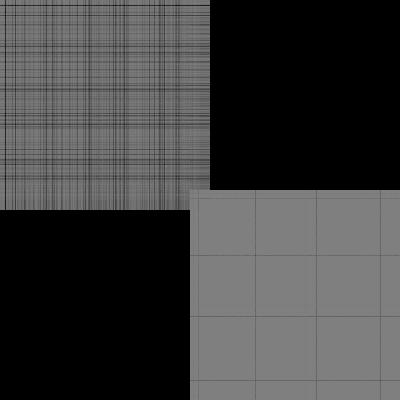

2.80


In [15]:
# Initialize state to initial conditions
# merged = tf.merge_all_summaries()
# train_writer = tf.train.SummaryWriter(FLAGS.summaries_dir + '/train', sess.graph)

# sess = tf.Session()
sess.run(tf.initialize_all_variables())
# with sess.as_default():
if 1:
    vm=[]
    um=[]
    vvm=[]
    im=[]
    gamma=[]
    t0 = time.time()
    for i in range(400):
        # Step simulation
        sess.run([step], feed_dict={dt: dtVal, tauv: 15, sim_index: i})
        feed = {dt: dtVal, tauv: 15,sim_index: i}
        sess.run(spike_update, feed_dict=feed)
        vvm.append(vvmean.eval())
        # Visualize every 50 steps
        if i % 10 == 0:
            pass
#             summary = sess.run(merged, feed_dict={dt: dtVal, tauv: 15})
#             train_writer.add_summary(summary, i)
            clear_output(wait=True)
            DisplayArray(wGap.eval(), rng=[0, 2*g0])
            vm.append(vmean.eval())
            um.append(umean.eval())
            im.append(imean.eval())
            gamma.append(gammamean.eval())
#         if i % 100 == 0:
#             run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#             run_metadata = tf.RunMetadata()
#             train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
        
print('%.2f'%(time.time()-t0))
# sess.close()

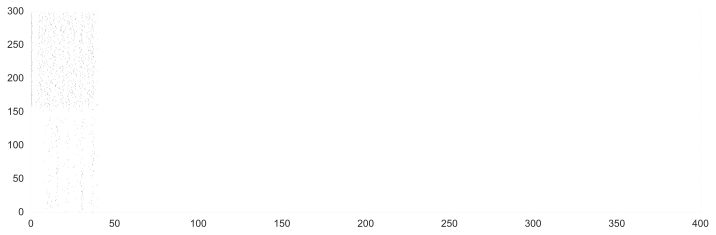

In [16]:
sp =tf.convert_to_tensor(spikes).eval()
plt.figure(figsize=(12,4))
extent=[0,400,0,300]
plt.imshow(sp.transpose(), extent=extent, aspect=0.3*(extent[1] - extent[0]) / (
            extent[3] - extent[2]))

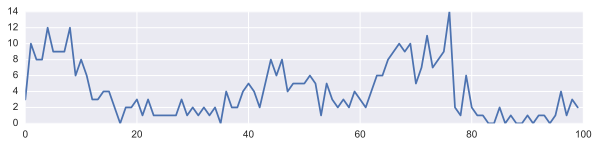

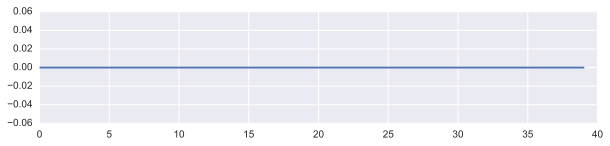

In [17]:
plt.figure(figsize=(10,2))
plt.plot(vvm[-100:])
plt.figure(figsize=(10,2))
plt.plot(np.array(gamma)*N**2)

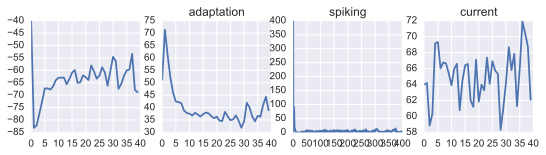

In [18]:
fig = plt.figure(figsize=(9,2))
ax0 = fig.add_subplot(141)
ax1 = fig.add_subplot(142)
ax2 = fig.add_subplot(143)
ax3 = fig.add_subplot(144)

ax0.plot(vm)

ax1.plot(um)
ax1.set_title('adaptation')

ax2.plot(vvm)
ax2.set_title('spiking')

ax3.plot(im)
ax3.set_title('current')